In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, Matern

from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras import losses, optimizers

from carl.ratios import ClassifierScoreRatio
from carl.learning import CalibratedClassifierScoreCV

In [2]:
data_dir = '../data'
t = 0
theta1 = 708

In [3]:
def loss_function_carl(y_true, y_pred):
    return losses.binary_crossentropy(y_true[:, 0], y_pred[:, 0])

def make_classifier(n_hidden_layers=3,
                    hidden_layer_size=100,
                    activation='tanh',
                    dropout_prob=0.0):
    # Inputs
    input_layer = Input(shape=(42,))

    # Network
    hidden_layer = Dense(hidden_layer_size, activation=activation)(input_layer)
    if n_hidden_layers > 1:
        hidden_layer_ = hidden_layers(n_hidden_layers - 1,
                                      hidden_layer_size=hidden_layer_size,
                                      activation=activation,
                                      dropout_prob=dropout_prob)
        hidden_layer = hidden_layer_(hidden_layer)
    s_hat_layer = Dense(1, activation='sigmoid')(hidden_layer)

    # Combine outputs
    model = Model(inputs=[input_layer], outputs=[s_hat_layer])

    # Compile model
    model.compile(loss=loss_function_carl,
                  optimizer=optimizers.Adam(clipnorm=1.))

    return model

In [4]:
# Load data
X_train = np.load(data_dir + '/unweighted_events/X_train_point_by_point_' + str(t) + '_debug.npy')
y_train = np.load(data_dir + '/unweighted_events/y_train_point_by_point_' + str(t) + '_debug.npy')
X_calibration = np.load(data_dir + '/unweighted_events/X_calibration_debug.npy')
weights_calibration = np.load(
    data_dir + '/unweighted_events/weights_calibration_debug.npy')
    
# Scale data
scaler = StandardScaler()
scaler.fit(np.array(X_train, dtype=np.float64))
X_train_transformed = scaler.transform(X_train)
X_calibration_transformed = scaler.transform(X_calibration)

clf = KerasRegressor(lambda: make_classifier(n_hidden_layers=1),
                     epochs=1, validation_split=0.142857,
                     verbose=2)

# Training
clf.fit(X_train_transformed, y_train)

# Calibration
nc = X_calibration_transformed.shape[0]
X_calibration_both = np.zeros((2 * nc, X_calibration_transformed.shape[1]))
X_calibration_both[:nc] = X_calibration_transformed
X_calibration_both[nc:] = X_calibration_transformed
y_calibration = np.zeros(2 * nc)
y_calibration[nc:] = 1.
w_calibration = np.zeros(2 * nc)
w_calibration[:nc] = weights_calibration[t]
w_calibration[nc:] = weights_calibration[theta1]

ratio_calibrated = ClassifierScoreRatio(
    CalibratedClassifierScoreCV(clf, cv='prefit', bins=50, independent_binning=False)
)
ratio_calibrated.fit(X_calibration_both, y_calibration, sample_weight=w_calibration)

Train on 8571 samples, validate on 1429 samples
Epoch 1/1
 - 1s - loss: 0.2537 - val_loss: 0.0402


ClassifierScoreRatio(base_estimator=CalibratedClassifierScoreCV(base_estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x107485dd8>,
              bins=50, cv='prefit', independent_binning=False,
              interpolation=None, method='histogram', variable_width=False),
           prefit=None, random_state=None)

In [5]:
cal0 = ratio_calibrated.classifier_.calibrators_[0].calibrator0
cal1 = ratio_calibrated.classifier_.calibrators_[0].calibrator1

In [9]:
print(cal1.histogram_)

[ 0.          0.          0.51826538  1.22350663  1.58347027 11.12710427
 31.23760218 28.7856447  26.56997261 26.34788663 25.9508812  20.90833289
 17.38765434  8.69452294  9.29624324  6.19156923  5.13798298  2.40775984
  2.49342172  1.4472565   2.08356245  0.48939073  0.95938929  0.53766095
  0.72373918  0.39650762  0.          0.32838861  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]


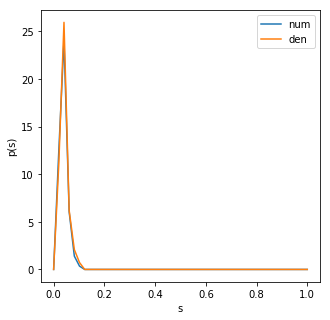

In [16]:
plt.figure(figsize=(5,5))

reals = np.linspace(0.,1.)

plt.plot(reals, cal0.pdf(reals.reshape(-1, 1)), label="num")
plt.plot(reals, cal1.pdf(reals.reshape(-1, 1)), label="den")

plt.legend()

plt.ylabel('p(s)')
plt.xlabel('s')

plt.show()

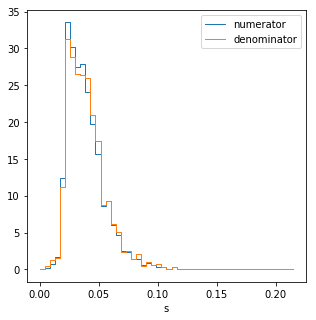

In [17]:
plt.figure(figsize=(5,5))

num_hist = np.hstack([cal0.histogram_, [0.]])
num_edges = cal0.edges_[0]
den_hist = np.hstack([cal1.histogram_, [0.]])
den_edges = cal1.edges_[0]

plt.step(num_edges, num_hist,
         where='post',
         alpha=0.2, lw=0., fillstyle='full',
         color='C0')
plt.step(den_edges, den_hist,
         where='post',
         alpha=0.2, lw=0., fillstyle='full',
         color='C1')
plt.step(num_edges, num_hist,
         where='post',
         alpha=1., lw=1., fillstyle='none',
         color='C0', label='numerator')
plt.step(den_edges, den_hist,
         where='post',
         alpha=1., lw=1., fillstyle='none',
         color='C1', label='denominator')

plt.xlabel('s')
plt.legend()

plt.show()